In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/DDD')
os.getcwd() #查看當前路徑

'/content/gdrive/MyDrive/DDD'

In [ ]:
!ls

DDD_1.ipynb	      inceptionV3_imagenet_split_on_subject.h5
DDD_2.ipynb	      pickle
DDD_3.ipynb	      sample_submission.csv
DDD_4.ipynb	      train_image.pickle
driver_imgs_list.csv  xception_imagenet_split_on_subject.h5
image_label.pickle    xception_random_initialization_split_on_subject.h5
imgs.zip


In [ ]:
import pickle

with open('train_image.pickle','rb') as f1:
  train_image = pickle.load(f1)

In [ ]:
len(train_image)

22424

In [ ]:
import random
random.shuffle(train_image)

In [ ]:
drivers = []
for F,L,D in train_image:
    drivers.append(D)
drivers = list(set(drivers))
len(drivers)

26

In [ ]:
drivers[:4]

['p015', 'p051', 'p039', 'p014']

# Split on subjects

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
drivers_train = []
drivers_val = []

for F,L,D in train_image:
    if D in drivers[:4]:
        drivers_val.append(D)
        x_val.append(F)
        y_val.append(L)
    else:
        drivers_train.append(D)
        x_train.append(F)
        y_train.append(L)

print(len(x_train))
print(len(x_val))

19102
3322


In [ ]:
import numpy as np

# Converting images to nparray
x_train = np.array(x_train).reshape(-1,140,140,3) #等於.reshape(19181,140,140,3)
x_val = np.array(x_val).reshape(-1,140,140,3)

print (x_train.shape)

(19102, 140, 140, 3)


In [ ]:
import tensorflow as tf

tf.__version__

'2.4.0'

In [ ]:
# one_hot_encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

print(y_train.shape)

(19102, 10)


In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

InceptionV3_conv = InceptionV3(weights= None, include_top=False, input_shape= (140,140,3)) #random initialization
InceptionV3_conv.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 140, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 69, 69, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 69, 69, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 69, 69, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
inputs = tf.keras.layers.Input(shape=(140,140,3), name='Image_Input')
InceptionV3_output = InceptionV3_conv(inputs)
x = tf.keras.layers.Flatten()(InceptionV3_output)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_Input (InputLayer)     [(None, 140, 140, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                184330    
Total params: 21,987,114
Trainable params: 21,952,682
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('inceptionV3_random_initialization_split_on_subject.h5', monitor='val_loss', save_best_only=True)
#earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2 )
#callbacks_list = [checkpointer, earlystopper]


datagen = tf.keras.preprocessing.image.ImageDataGenerator()

data_generator = datagen.flow(x_train, y_train, batch_size = 32)
inceptionV3_model = model.fit_generator(
    data_generator,steps_per_epoch = len(x_train)/32,
    epochs = 10,
    validation_data = (x_val,y_val),
    callbacks = checkpointer)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
596/596 [==============================] - 80s 111ms/step - loss: 3.5084 - accuracy: 0.2073 - val_loss: 15.0198 - val_accuracy: 0.4272
Epoch 2/10
596/596 [==============================] - 67s 112ms/step - loss: 0.5300 - accuracy: 0.8539 - val_loss: 1.8699 - val_accuracy: 0.6069
Epoch 3/10
596/596 [==============================] - 66s 111ms/step - loss: 0.2847 - accuracy: 0.9216 - val_loss: 1.7195 - val_accuracy: 0.6514
Epoch 4/10
596/596 [==============================] - 66s 111ms/step - loss: 0.1411 - accuracy: 0.9619 - val_loss: 2.3061 - val_accuracy: 0.5810
Epoch 5/10
596/596 [==============================] - 66s 111ms/step - loss: 0.1461 - accuracy: 0.9570 - val_loss: 1.9469 - val_accuracy: 0.6370
Epoch 6/10
596/596 [==============================] - 66s 110ms/step - loss: 0.0740 - accuracy: 0.9769 - val_loss: 2.2197 - val_accuracy: 0.6192
Epoch 7/10
596/596 [==============================] - 66s 110ms/step - loss: 0.0819 - accuracy: 0.9757 - val_loss: 2.0383 - val_a

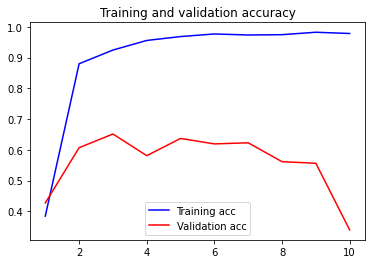

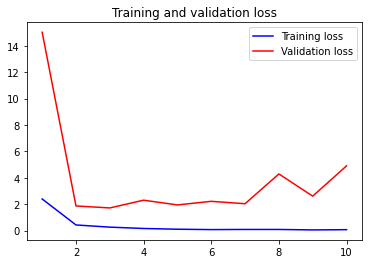

In [ ]:
import matplotlib.pyplot as plt

acc = inceptionV3_model.history['accuracy']
val_acc = inceptionV3_model.history['val_accuracy']
loss = inceptionV3_model.history['loss']
val_loss = inceptionV3_model.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
with open('InceptionV3_random_initialization_acc.pickle','wb') as f:
  pickle.dump([acc,val_acc,loss,val_loss],f)

In [ ]:
with open('InceptionV3_random_initialization_acc.pickle','rb') as f:
  [acc,val_acc,loss,val_loss] = pickle.load(f)

print(acc)

[0.3844623565673828, 0.8798031806945801, 0.9243534803390503, 0.9555543661117554, 0.9682232141494751, 0.976651668548584, 0.9733012318611145, 0.974348247051239, 0.9822531938552856, 0.9781697988510132]


In [ ]:
print(acc)
print(val_acc)

[0.3844623565673828, 0.8798031806945801, 0.9243534803390503, 0.9555543661117554, 0.9682232141494751, 0.976651668548584, 0.9733012318611145, 0.974348247051239, 0.9822531938552856, 0.9781697988510132]
[0.4271523058414459, 0.6068633198738098, 0.6514148116111755, 0.5809752941131592, 0.6369656920433044, 0.6192052960395813, 0.6228175759315491, 0.5614088177680969, 0.556291401386261, 0.33955448865890503]
